In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from scipy.interpolate import interp1d

# 1. Exact calculation
First, we compute distances and growth exactly

In [2]:
zmax = 1100.
pars = {'Omega_c': 0.25, 'Omega_b': 0.05, 'h': 0.67, 'n_s': 0.96, 'sigma8': 0.8}
cosmo = ccl.Cosmology(**pars)
zfine = np.linspace(0, zmax, 1000000)
afine = 1./(1+zfine)
xfine = np.log(1+zfine)
chi_i = ccl.comoving_angular_distance(cosmo, afine)
dd_i = ccl.growth_factor(cosmo, afine)
ddp_i = ccl.growth_rate(cosmo, afine)*dd_i
ddp_i *= cosmo['sigma8']/dd_i[0]
dd_i *= cosmo['sigma8']/dd_i[0]

# 2. Distances
Now we compute distances using $x=\log(1+z)$ as an integration variable. We will use linear interpolation to evaluate the result on the fine grid of redshifts defined above.

$$
\chi(z) = \int_0^z d\log(1+z)\, \frac{c(1+z)}{H(z)}
$$

In [8]:
def my_cumsum(a, order=0):
    ''' Cumulative sum enforcing zero integral in the first element.
    If order!=0 trapezoidal integration will be used.'''
    r = np.zeros(len(a)+1)
    r[1:] = np.cumsum(a)
    if order == 0:  # Rectangular integration
        return r[:-1]
    else:  # Trapezoidal integration
        return 0.5*(r[1:]+r[:-1])#-0.5*r[1]
    return r

def get_chi(z, hz, dx, order=0):
    ''' Computes the radial comoving distance numerically from
    an array of H(z).'''
    return dx*my_cumsum((1+z)/hz, order=order)

def compute_chi(nz, zout):
    # Equi-spaced log(1+z)
    x = np.linspace(0, np.log(1+zmax), nz)
    dx = np.mean(np.diff(x))
    z = np.exp(x)-1
    a = 1./(1+z)
    # H(z) (in Jaime's case this would be the GP)
    hz = ccl.h_over_h0(cosmo, a)*cosmo['h']/ccl.physical_constants.CLIGHT_HMPC
    # 0th order integral
    chiz_0 = get_chi(z, hz, dx, order=0)
    # 1st order integral
    chiz_1 = get_chi(z, hz, dx, order=1)

    # Interpolate onto a fine grid
    chiz_0i = interp1d(x, chiz_0, kind='linear', fill_value=0, bounds_error=False)
    chiz_1i = interp1d(x, chiz_1, kind='linear', fill_value=0, bounds_error=False)
    return zout, chiz_0i(np.log(1+zout)), chiz_1i(np.log(1+zout))

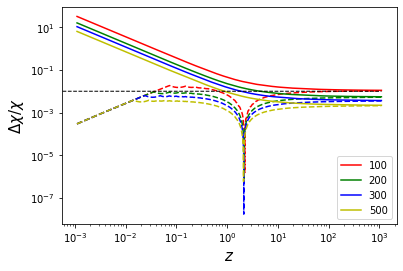

In [9]:
# Compute and compare with exact calculation
zz, chi0_100, chi1_100 = compute_chi(100, zfine)
zz, chi0_200, chi1_200 = compute_chi(200, zfine)
zz, chi0_300, chi1_300 = compute_chi(300, zfine)
zz, chi0_500, chi1_500 = compute_chi(500, zfine)
plt.plot(zz[1:], np.fabs(chi0_100[1:]/chi_i[1:]-1), 'r--')
plt.plot(zz[1:], np.fabs(chi1_100[1:]/chi_i[1:]-1), 'r-', label='100')
plt.plot(zz[1:], np.fabs(chi0_200[1:]/chi_i[1:]-1), 'g--')
plt.plot(zz[1:], np.fabs(chi1_200[1:]/chi_i[1:]-1), 'g-', label='200')
plt.plot(zz[1:], np.fabs(chi0_300[1:]/chi_i[1:]-1), 'b--')
plt.plot(zz[1:], np.fabs(chi1_300[1:]/chi_i[1:]-1), 'b-', label='300')
plt.plot(zz[1:], np.fabs(chi0_500[1:]/chi_i[1:]-1), 'y--')
plt.plot(zz[1:], np.fabs(chi1_500[1:]/chi_i[1:]-1), 'y-', label='500')
plt.plot(zz, np.ones_like(zz)*0.01, 'k--', lw=1)
plt.loglog()
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$\Delta\chi/\chi$', fontsize=15)
plt.legend(loc='lower right')
plt.show()

# 3 Growth

The growth equation can be written as
$$
\frac{d}{da}\left(a^2H\frac{dD}{d\log a}\right)=\frac{3}{2}\Omega_M(a)\,a\,H\,D
$$

Defining $y\equiv a^2E\frac{dD}{d\log a}$ (with $E\equiv H/H_0$), and switching to the integration variable $x\equiv\log(1+z)$, this equation can be written in terms of a system of couple of first-order equations:
$$
\frac{dy}{dx}=-\frac{3}{2}\frac{\Omega_M}{a E}D,
$$
$$
\frac{dD}{dx}=-\frac{y}{a^2E}.
$$
with initial condition:
$$
D(a_{ini})=a_{ini},\hspace{12pt}y(a_{ini})=a^3_{ini}E(a_{ini})
$$

Note that this system of equations can be written in matrix form as:
$$
\frac{d}{dx}
\left(
\begin{array}{c}
y \\ D
\end{array}
\right)
=
\left(
\begin{array}{cc}
0 & A(x) \\ B(x) & 0
\end{array}
\right)
\left(
\begin{array}{c}
y \\ D
\end{array}
\right)
$$
with
$$
A(x)=-\frac{3}{2}\frac{\Omega_M}{a(x)E(x)},\hspace{12pt}
B(x)=-\frac{1}{a^2(x)\,E(x)}
$$

After a little bit of algebra it's possible to show that the order-2 Runge-Kutta iteration for this system is:
$$
 y_{n+1}=\left(1+\frac{dx^2}{2}A(x_n)B(x_n)\right)y_n+\frac{dx}{2}\left(A(x_n)+A(x_{n+1})\right)D_n
$$
$$
 D_{n+1}=\frac{dx}{2}\left(B(x_n)+B(x_{n+1})\right)y_n+\left(1+\frac{dx^2}{2}A(x_n)B(x_n)\right)D_n
$$


In [5]:
def get_growth(x, e, Om):
    ''' Find D(x) and y(x) from an array of E(z)
    using RK2.
    '''
    xx = x[::-1]
    ee = e[::-1]
    aa = np.exp(-xx)
    dx = np.mean(np.diff(xx))

    nz = len(aa)
    dd = np.zeros(nz)
    yy = np.zeros(nz)
    dd[0] = aa[0]
    yy[0] = aa[0]**3*e[0]
    for i in range(nz-1):
        A0 = -1.5*Om/(aa[i]*ee[i])
        B0 = -1./(aa[i]**2*ee[i])
        A1 = -1.5*Om/(aa[i+1]*ee[i+1])
        B1 = -1./(aa[i+1]**2*ee[i+1])
        yy[i+1]=(1+0.5*dx**2*A0*B0)*yy[i]+0.5*(A0+A1)*dx*dd[i]
        dd[i+1]=0.5*(B0+B1)*dx*yy[i]+(1+0.5*dx**2*A0*B0)*dd[i]
    return dd[::-1], yy[::-1]

def compare_growth(nz, zout):
    # Equi-spaced in log(1+z)
    x = np.linspace(0, np.log(1+zmax), nz)
    a = np.exp(-x)
    cosmo = ccl.Cosmology(**pars)
    Om = cosmo['Omega_c']+cosmo['Omega_b']
    # H(z) (in Jaime's case this would be the GP)
    e = ccl.h_over_h0(cosmo, a)
    d, y = get_growth(x, e, Om)
    # Transform into sigma8 (d) and fsigma8 (dp)
    print(y)
    dp = y * cosmo['sigma8']/ (a**2*e*d[0])
    d = d * cosmo['sigma8']/ d[0]

    # Interpolate onto a fine grid
    d_i = interp1d(x, d, kind='linear', fill_value=0, bounds_error=False)
    dp_i = interp1d(x, dp, kind='linear', fill_value=0, bounds_error=False)
    return zout, d_i(np.log(1+zout)), dp_i(np.log(1+zout))

[2.00154034e-01 1.87712780e-01 1.75340880e-01 1.63139687e-01
 1.51208483e-01 1.39640049e-01 1.28516628e-01 1.17906761e-01
 1.07863284e-01 9.84226124e-02 8.96052060e-02 8.14169979e-02
 7.38514440e-02 6.68918957e-02 6.05140088e-02 5.46879840e-02
 4.93805328e-02 4.45565110e-02 4.01802007e-02 3.62162910e-02
 3.26305733e-02 2.93904168e-02 2.64650729e-02 2.38258375e-02
 2.14461150e-02 1.93014039e-02 1.73692415e-02 1.56291065e-02
 1.40623027e-02 1.26518475e-02 1.13823600e-02 1.02399137e-02
 9.21189168e-03 8.28691067e-03 7.45470737e-03 6.70601117e-03
 6.03247642e-03 5.42657838e-03 4.88153904e-03 4.39125664e-03
 3.95023519e-03 3.55353153e-03 3.19669335e-03 2.87571750e-03
 2.58699949e-03 2.32729805e-03 2.09369611e-03 1.88356989e-03
 1.69455922e-03 1.52454048e-03 1.37160440e-03 1.23403241e-03
 1.11028007e-03 9.98957027e-04 8.98813568e-04 8.08725012e-04
 7.27680101e-04 6.54769103e-04 5.89173701e-04 5.30158061e-04
 4.77059972e-04 4.29284262e-04 3.86295137e-04 3.47611054e-04
 3.12798551e-04 2.814679

[2.01451839e-01 1.98969774e-01 1.96487186e-01 1.94004849e-01
 1.91523541e-01 1.89044049e-01 1.86567165e-01 1.84093683e-01
 1.81624402e-01 1.79160122e-01 1.76701641e-01 1.74249758e-01
 1.71805268e-01 1.69368961e-01 1.66941623e-01 1.64524031e-01
 1.62116955e-01 1.59721156e-01 1.57337381e-01 1.54966366e-01
 1.52608834e-01 1.50265492e-01 1.47937031e-01 1.45624124e-01
 1.43327426e-01 1.41047573e-01 1.38785180e-01 1.36540840e-01
 1.34315126e-01 1.32108585e-01 1.29921743e-01 1.27755101e-01
 1.25609135e-01 1.23484296e-01 1.21381011e-01 1.19299679e-01
 1.17240675e-01 1.15204348e-01 1.13191021e-01 1.11200989e-01
 1.09234525e-01 1.07291875e-01 1.05373257e-01 1.03478868e-01
 1.01608879e-01 9.97634368e-02 9.79426640e-02 9.61466609e-02
 9.43755049e-02 9.26292517e-02 9.09079355e-02 8.92115699e-02
 8.75401487e-02 8.58936465e-02 8.42720197e-02 8.26752069e-02
 8.11031292e-02 7.95556916e-02 7.80327839e-02 7.65342818e-02
 7.50600461e-02 7.36099246e-02 7.21837534e-02 7.07813562e-02
 6.94025458e-02 6.804712

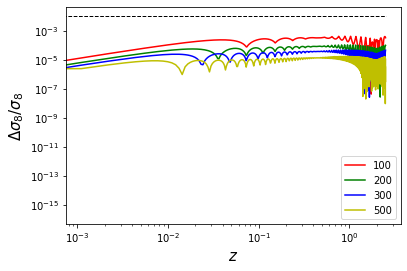

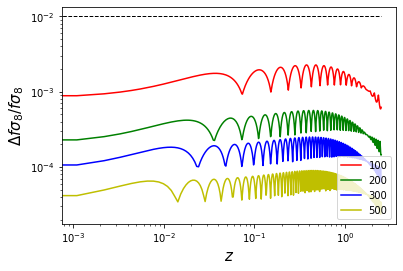

In [6]:
# Compute and compare with exact calculation
zz, d_100, dp_100 = compare_growth(100, zfine)
zz, d_200, dp_200 = compare_growth(200, zfine)
zz, d_300, dp_300 = compare_growth(300, zfine)
zz, d_500, dp_500 = compare_growth(500, zfine)
msk = zz < 2.5

plt.figure()
plt.plot(zz[msk], np.fabs(d_100/dd_i-1)[msk], 'r-', label='100')
plt.plot(zz[msk], np.fabs(d_200/dd_i-1)[msk], 'g-', label='200')
plt.plot(zz[msk], np.fabs(d_300/dd_i-1)[msk], 'b-', label='300')
plt.plot(zz[msk], np.fabs(d_500/dd_i-1)[msk], 'y-', label='500')
plt.plot([0, 2.5], [0.01, 0.01], 'k--', lw=1)
plt.loglog()
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$\Delta \sigma_8/\sigma_8$', fontsize=15)
plt.legend(loc='lower right')
plt.figure()
plt.plot(zz[msk], np.fabs(dp_100/ddp_i-1)[msk], 'r-', label='100')
plt.plot(zz[msk], np.fabs(dp_200/ddp_i-1)[msk], 'g-', label='200')
plt.plot(zz[msk], np.fabs(dp_300/ddp_i-1)[msk], 'b-', label='300')
plt.plot(zz[msk], np.fabs(dp_500/ddp_i-1)[msk], 'y-', label='500')
plt.plot([0, 2.5], [0.01, 0.01], 'k--', lw=1)
plt.loglog()
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$\Delta f\sigma_8/f\sigma_8$', fontsize=15)
plt.legend(loc='lower right')
plt.show()

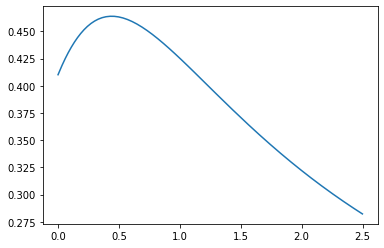

In [7]:
plt.plot(zz[msk], dp_300[msk])